In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import time

Using TensorFlow backend.


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling for an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
# Init a normalization funciton
def normalization(matrix, max_val, min_val):
    new_matrix = np.array([((image - min_val) / (max_val - min_val)) for image in matrix])
    return new_matrix

In [4]:
# from https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
# Class which enables to store the execution time per epoch
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


def acc_time(time_stamps):
    # accumulate all single time values
    accumulated_time = []
    acc_time = 0
    for time in time_stamps:
        acc_time += time
        accumulated_time.append(acc_time)
    # print(accumulated_time)
    return accumulated_time


def run_model(model, x_train, x_test):
    # compile the given model architecture
    model.compile(optimizer='sgd')

    # call class for taking time stamps for each epoch
    time_callback_train = TimeHistory()
    

    # fit the model (train the network) and save meplt.savefig('vae_loss_epoch.png')plt.savefig('vae_loss_epoch.png')trics in variable history
    history = model.fit(x_train, epochs=50, batch_size=200, validation_data=(x_test, None), callbacks=[time_callback_train])

    # store time stamps per epoch in variable
    times_train = time_callback_train.times
    print()
    print("Reported times per epoch: \n ", times_train)

    accumulated_time = acc_time(times_train)

    # Evaluate model using testing dataset
    test_start_time = time.time()
    test_loss = model.evaluate(x_test, batch_size=1000, verbose=2)
    print()
    print()
    print('Test Loss: {}'.format(test_loss))
    test_end_time = time.time() - test_start_time
    print('Time for Testing Data: ', test_end_time)

    # Plot training loss values vs epochs
    plt.plot(history.history['loss'])
    plt.title('Model Loss vs. Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training time vs epochs
    plt.plot(accumulated_time, history.history['loss'])
    plt.title('Model Loss vs. Time')
    plt.ylabel('Loss')
    plt.xlabel('Time in seconds')
    plt.legend(['Train'], loc='upper left')
    plt.show()

    return history

In [5]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get min, and max value from training data set using all 60,000 samples
max_val = x_train.max()
# print("Maximal value: ", max_val)
min_val = x_train.min()

# Normalize training (x_train) and testing (x_test) data based on maximal/minimal values of the training data
x_train_scaled = normalization(x_train, max_val, min_val)
x_test_scaled = normalization(x_test, max_val, min_val)

# Reshape data 
image_size = x_train_scaled.shape[1]
reshaped_x_train_scaled = np.reshape(x_train_scaled, [-1, image_size, image_size, 1])
reshaped_x_test_scaled = np.reshape(x_test_scaled, [-1, image_size, image_size, 1])

In [6]:
print(image_size)
print(reshaped_x_train_scaled.shape, reshaped_x_test_scaled.shape)

28
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [9]:
# network parameters
input_shape = (image_size, image_size, 1)
kernel_size = 3
filters = 16 
latent_dim = 32

In [10]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    
# shape info needed to build decoder model
shape = K.int_shape(x)
print(shape)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

(None, 7, 7, 64)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_4[0][0]                   
___________________________________________________________________________

In [11]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              103488    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 159,169
Trainable params: 159,169
Non-trainable params: 0
_____________________________________________________

In [10]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  70096     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         159169    
Total params: 229,265
Trainable params: 229,265
Non-trainable params: 0
_________________________________________________________________


In [11]:
# set loss 
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

/Users/annanau/anaconda3/envs/tf2/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 36s 608us/step - loss: 97.4079 - val_loss: 96.9201
Epoch 2/50
60000/60000 [==============================] - 37s 617us/step - loss: 97.8429 - val_loss: 97.4088
Epoch 3/50
60000/60000 [==============================] - 38s 630us/step - loss: 97.7355 - val_loss: 97.5013
Epoch 4/50
60000/60000 [==============================] - 37s 615us/step - loss: 97.7091 - val_loss: 97.3875
Epoch 5/50
60000/60000 [==============================] - 36s 593us/step - loss: 84.3670 - val_loss: 76.8695
Epoch 6/50
60000/60000 [==============================] - 35s 581us/step - loss: 68.0420 - val_loss: 56.0095
Epoch 7/50
60000/60000 [==============================] - 35s 581us/step - loss: 53.8106 - val_loss: 46.6526
Epoch 8/50
60000/60000 [==============================] - 35s 588us/step - loss: 42.8568 - val_loss: 39.1585
Epoch 9/50
60000/60000 [==============================] - 36s 600us/step - los

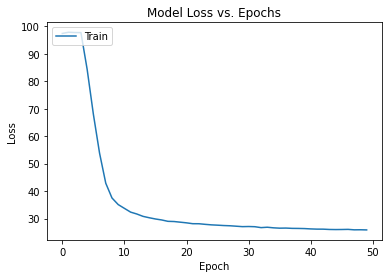

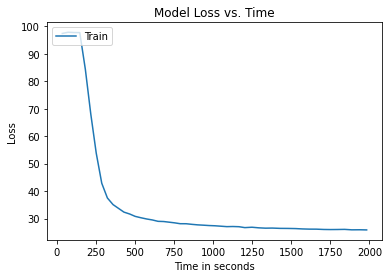

In [12]:
history = run_model(vae, reshaped_x_train_scaled, reshaped_x_test_scaled)

In [13]:
# =============================================
# Take a sample for visualization purposes
# =============================================
input_sample = reshaped_x_train_scaled[:1]
reconstruction = vae.predict([input_sample])

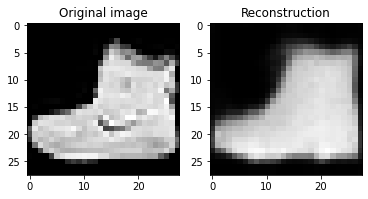

In [16]:
# =============================================
# Visualize input-->reconstruction
# =============================================
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(6, 3.5)
input_sample_reshaped = input_sample.reshape((28, 28))
reconsstruction_reshaped = reconstruction.reshape((28, 28))
axes[0].imshow(input_sample_reshaped, cmap='gray') 
axes[0].set_title('Original image')
axes[1].imshow(reconsstruction_reshaped, cmap='gray')
axes[1].set_title('Reconstruction')
plt.show()

In [19]:
output_encoder = encoder.predict(reshaped_x_train_scaled)
print(len(output_encoder))

3


In [20]:
image = decoder.predict(np.array([output_encoder[2][0]]))
image = image.reshape((28,28))
print(image)

[[1.69664752e-02 6.07716804e-03 4.36121225e-03 5.39501710e-03
  6.41374709e-03 5.06000826e-03 8.44119210e-03 4.78102034e-03
  1.37284840e-03 7.30511732e-04 1.58297119e-03 3.77848325e-03
  8.31063651e-03 1.19351875e-02 2.46437974e-02 2.16924455e-02
  1.04202507e-02 5.70457336e-03 4.24071727e-03 4.77045681e-03
  5.43096755e-03 4.29150788e-03 6.28417078e-03 6.30007917e-03
  5.36565762e-03 4.50070156e-03 4.91621532e-03 1.01580061e-02]
 [8.71917885e-03 2.75483215e-03 1.26668811e-03 1.86925381e-03
  1.65582891e-03 1.27476023e-03 1.53122109e-03 7.78032292e-04
  1.64872588e-04 1.28888831e-04 2.74249847e-04 1.82695757e-03
  5.58855478e-03 1.21260909e-02 1.70423761e-02 2.01003831e-02
  1.06402198e-02 7.13625504e-03 4.01601102e-03 5.03481133e-03
  2.87094945e-03 2.13761418e-03 2.02194555e-03 2.63137091e-03
  2.05886108e-03 1.79593626e-03 1.50548760e-03 3.15221236e-03]
 [6.05605496e-03 2.59152032e-03 1.17161765e-03 1.39965618e-03
  1.28444575e-03 1.10414042e-03 7.18981551e-04 3.53996875e-04
  1.00

In [21]:
max = output_encoder[2].max()
min = output_encoder[2].min()
print(max, min)

5.4659266 -4.7997932


In [60]:
#latent = np.random.rand(32)
latent = np.random.normal(0, 1, 32)
#latent = np.random.rand(32)*(max - min) + min
decoded_img = decoder.predict(np.array([latent]))
decoded_img = decoded_img[0].reshape(28, 28)
print(decoded_img.shape)

(28, 28)


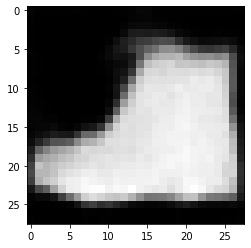

In [61]:
plt.figure()
plt.gray()
plt.imshow(image)

In [67]:
rand_latents = []
for i in range(10):
    random_latent = np.random.normal(0, 1, 32)
    decoded_img = decoder.predict(np.array([random_latent]))
    decoded_img_reshape = np.reshape(decoded_img,(28,28))
    rand_latents.append(decoded_img_reshape)

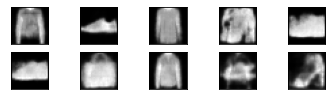

In [72]:
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.gray()
    plt.grid(False)
    plt.imshow(rand_latents[i])
plt.savefig('latent_vec_img.png')
plt.show()

In [71]:
np.random.normal(0, 1, 32)

array([-1.32037103, -1.3550233 , -0.50794681,  1.22933885,  0.67858292,
       -0.53179348,  0.89579833, -0.19877655,  0.76357474,  0.08349087,
        0.34069923,  1.08775654, -0.01730444,  0.57644287,  0.15164235,
        0.03691859, -2.19640885, -0.73877545, -0.16384047,  0.63882505,
        0.80116266, -0.59567757, -0.38875735,  0.0342079 ,  1.43902818,
        1.02457623, -0.86560232, -0.05023889, -0.20625724,  0.01331181,
       -1.41289474, -0.94238521])